### Inference Script

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import tqdm as tqdm
import utils
from typing import Tuple, Dict
import cv2
import torch.nn.functional as F




In [3]:
#Defining configurations
class Configuration:
    MODEL_SAVEPATH = "models/"
    ENCODER = "efficientnet-b2"#"se_resnext101_32x4d"#"se_resnext50_32x4d"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    PRETRAINED_WEIGHTS = "imagenet"
    INPUT_CHANNELS = 3
    CLASSES = 2
    PREPROCESS = sm.encoders.get_preprocessing_fn(ENCODER,PRETRAINED_WEIGHTS)
    

cfg = Configuration()  

In [4]:


def pad_image(image:np.ndarray,pad_for_stride:Tuple = (512,512))->np.ndarray:
    """
    Adds padding to the image based on the stride side
    
    """
    if len(image.shape) == 2:
        padded_imag = np.ones((int(np.ceil(image.shape[0]/pad_for_stride[0])*pad_for_stride[0]),int(np.ceil(image.shape[1]/pad_for_stride[1])*pad_for_stride[1])),np.uint8)
        padded_imag.fill(255)
        for col in range(image.shape[1]):
            padded_imag[:,col][0:image.shape[0]] = image[:,col][:]
    else:
        padded_imag = np.ones((int(np.ceil(image.shape[0]/pad_for_stride[0])*pad_for_stride[0]),int(np.ceil(image.shape[1]/pad_for_stride[1])*pad_for_stride[1]),image.shape[-1]),np.uint8)
        padded_imag.fill(255)
        for col in range(image.shape[1]):
            padded_imag[:,col,:][0:image.shape[0]] = image[:,col,:][:]
        
    return padded_imag


def unpad_image(image:np.ndarray,original_dim:Tuple = (4536,4704))->np.ndarray:
    """
    removes pad from the image based on original shape
    """
    return image[0:original_dim[0],0:original_dim[1]]




def tile_generator(image:np.ndarray,tile_size:Tuple = (512,512))->list:
    
    """
    Method to generate tiles out of the images
    
    inputs:
    image : np.ndarray = (image array)
    tile_size : Tuple = Tuple with tile size information
    
    
    """
    cx,cy = 0,0
    max_height = image.shape[0]
    max_width = image.shape[1]
    tile = []
    while cy+tile_size[0] <= max_height: 
        width_wise_tiles = []
        while cx+tile_size[1] <= max_width:
            width_wise_tiles.append(image[cy:cy+tile_size[0],cx:cx+tile_size[1]])  
            cx+=tile_size[1]
        cy+=tile_size[0]
        cx=0
        tile.append(width_wise_tiles)
    return tile

def average_over_predictions(model_l:list,image:torch.Tensor):
    """
    This methods do inference on all the models in the model_l input parameter, averages the
    predictions and returns them
    
    inputs:
    model_l : list = list of all the trained models
    image : torch.Tensor = Image on which inference is to be performed
    
    """
    prediction = torch.zeros((1,2,image.shape[2],image.shape[3])).to(cfg.DEVICE)
    for m in model_l:
        m.eval()
        
        with torch.no_grad():
            prediction+= F.softmax(m(image),1)
    return prediction/len(model_l)


def max_over_predictions(model_l:list,image:torch.Tensor):
    prediction = torch.zeros((1,2,len(model_l),image.shape[2],image.shape[3])).to(cfg.DEVICE)
    for i,m in enumerate(model_l):
        m.eval()
        
        with torch.no_grad():
            prediction[:,:,i,:,:]=F.softmax(m(image),1)
    return torch.max(prediction,2)[0]
            


def pred_mask(model_list:list,tiles:np.ndarray,mask_shape:Tuple,save_mask = True)->np.ndarray:
    """
    Method predicts on the tiles, generate masks and stitch back the mask as a whole image mask.

    
    """
    predicted_masks_of_all_patches = []
    patches_collected = []
    mask_acc = np.zeros((mask_shape))
    row = 0
    column = 0
    for i in range(tiles.shape[0]):
        
        
        for j in range(tiles.shape[1]):
            
            prep = preprocess(image = tiles[i,j])['image']
            prep = prep.unsqueeze(0)
            # p = torch.softmax(model(prep.to(cfg.DEVICE).float()),1)
            p = average_over_predictions(model_list,prep.to(cfg.DEVICE).float())
            predicted_mask = p[0][1].detach().cpu().numpy()>0.5
            
            if save_mask:
                patches_collected.append(tiles[i,j])
                predicted_masks_of_all_patches.append(predicted_mask)
            mask_acc[row:row+512,column:column+512] = predicted_mask
            
            column+=512
            
        row+=512
        column=0
            
            
    return mask_acc,patches_collected,predicted_masks_of_all_patches if save_mask else mask_acc
    
            
            
def rle_encode(img):
    #cite = https://www.kaggle.com/lifa08/run-length-encode-and-decode
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
        
    
def dice_score(y_pred, y_true, eps=1e-8):
    """
    calculate dicescore
    """
    y_pred = y_pred.ravel()>0
    y_true = y_true.ravel()>0
    
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred) + np.sum(y_true)
    

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice
  
    
def save_masks_(image_id:str,mask_list:list,original_patches:list)->None:
    
    if not os.path.isdir("result_patches/"+image_id):
        os.makedirs("result_patches/"+image_id)
    
    path = "result_patches/"+image_id+"/"
    for i,tile_mask in enumerate(mask_list):
        tile_mask = cv2.cvtColor(np.uint8(tile_mask*255),cv2.COLOR_GRAY2RGB)
        concat_image_mask = cv2.hconcat([np.uint8(original_patches[i]),tile_mask])
        io.imsave(path+image_id+f"_{i}.png",concat_image_mask)
        # io.imsave(path+image_id+f"image_{i}.png",tile_mask)
        
        
    
def prediction(models:list,data_path:str,dataframe:pd.DataFrame,save_masks:bool=True,csv_name:str="submission.csv"):
    dice = []
    submission = pd.DataFrame(columns=["img","pixels"])
    dice_report = pd.DataFrame(columns=["img","dice"])
    for i,row in enumerate(dataframe.iloc[:,0]):
        img_path = data_path+"/"+row+".tiff"
        mask_path = data_path+"_mask/"+row+".tiff"
        print("testing",row)
        imag = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        padded_image = pad_image(imag)
        tiles = np.array(tile_generator(padded_image))
        
        result = pred_mask(models,tiles,padded_image.shape[0:-1],save_mask=save_masks)
        if save_masks:
            save_masks_(row,result[2],result[1])
            
            result = result[0]
        result = unpad_image(result[0],(imag.shape[0],imag.shape[1],1))
        plt.imshow(result)
        plt.show()
        rle = rle_encode(result)
        dice.append(dice_score(result,mask))
        submission.loc[i,:] = [row,rle]
        dice_report.loc[i,:] = [row,dice_score(result,mask)]
    dice_report.loc[i+1,:] = ["Average",sum(dice)/len(dice)]
    dice_report.to_csv("dice_report_"+csv_name,index=False)
    submission.to_csv(csv_name,index=False)
    print("dice scores",dice)
    print("Average dice score is ",sum(dice)/len(dice))
        
        
        
    
preprocess  =utils.preprocessing_fucntion(cfg.PREPROCESS)
    
    
    
    

Loading models

In [5]:

model_List = []
for models in os.listdir("models/"):
    if ".pth" in models: 
    
        model = sm.Unet(encoder_name=cfg.ENCODER, 
                             encoder_weights=cfg.PRETRAINED_WEIGHTS, 
                             in_channels=cfg.INPUT_CHANNELS, 
                             classes=cfg.CLASSES)

        model.to(cfg.DEVICE)
        # device = "gpu"
        model.load_state_dict(torch.load(f"models/{models}"))
        model_List.append(model)


Dice on test data

In [6]:
df_test = pd.read_csv("Colonic_crypt_dataset/test.csv")
test_data_path = "Colonic_crypt_dataset/test"

testing CL_HandE_1234_B004_bottomleft


Shaped series: axes do not match shape


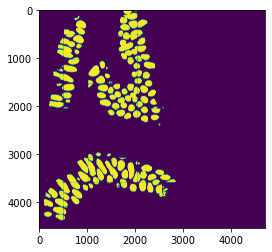

testing HandE_B005_CL_b_RGB_bottomleft


Shaped series: axes do not match shape


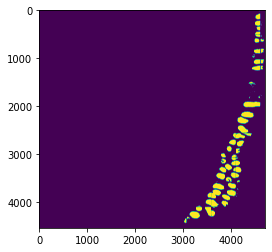

dice scores [0.922929778972226, 0.7634746349031302]
Average dice score is  0.8432022069376781


In [7]:
prediction(model_List,test_data_path,df_test,False,"submission.csv")

Training data dice calculation

testing CL_HandE_1234_B004_bottomright


Shaped series: axes do not match shape


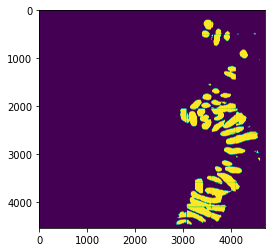

Shaped series: axes do not match shape


testing CL_HandE_1234_B004_topleft


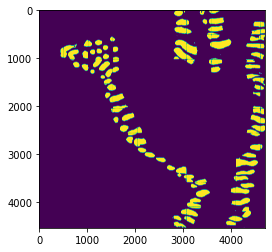

Shaped series: axes do not match shape


testing CL_HandE_1234_B004_topright


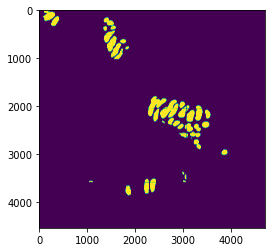

testing HandE_B005_CL_b_RGB_bottomright


Shaped series: axes do not match shape


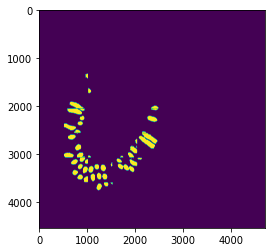

Shaped series: axes do not match shape


testing HandE_B005_CL_b_RGB_topleft


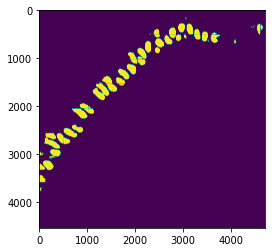

dice scores [0.936980592055458, 0.9195726177015423, 0.9216310830724985, 0.8983568682591906, 0.9104829978846856]
Average dice score is  0.9174048317946749


In [8]:
df_train = pd.read_csv("Colonic_crypt_dataset/train.csv").iloc[0:-1,:]
train_data_path = "Colonic_crypt_dataset/train"
prediction(model_List,train_data_path,df_train,False,"train_predictions.csv")

### Overlaying predictions

In [13]:
def test_prediction_overlays(test_data_path:str,model_list:list,dataframe,overlay_save_path:str,n_show=10000):
    """
    Method to do prediction on the test data, return the patches with ground truth and 
    predictions overlayed.
    
    """
    
    
    if not os.path.isdir(overlay_save_path):
        os.makedirs(overlay_save_path)
    for i,row in enumerate(dataframe.iloc[:,0]):
        print(f"overlays for {row}")
        img_path = test_data_path+"/"+row+".tiff"
        mask_path = test_data_path+"_mask/"+row+".tiff"
        imag = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        padded_image = pad_image(imag)
        padded_mask = pad_image(mask)
        tile_size = (512,512)
    
        cx,cy = 0,0
        max_height = imag.shape[0]
        max_width = imag.shape[1]
        feature = []
        feature_label = []
        image_id = 0
        while cy+tile_size[0] <= max_height: 
            if n_show==0:
                break
            while cx+tile_size[1] <= max_width:
                if n_show==0:
                    break
                mask_patch = padded_mask[cy:cy+tile_size[0],cx:cx+tile_size[1]]
                if len(np.unique(mask_patch))>1:
                    data = imag[cy:cy+tile_size[0],cx:cx+tile_size[1]]
                    data_img = preprocess(image = data)['image'].unsqueeze(0).to(cfg.DEVICE)
                    predicted_mask = (average_over_predictions(model_list,data_img.to(cfg.DEVICE).float()).detach().cpu().numpy() > 0.5)[0,1,:,:]
                    contours, hierarchy = cv2.findContours(np.uint8(predicted_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                    data_pred_overlay = cv2.drawContours(data.copy(), contours, -1, (0, 255, 0), 3)
                    contours, hierarchy = cv2.findContours(np.uint8(mask_patch), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                    data_gt_overlay = cv2.drawContours(data.copy(), contours, -1, (255, 0, 0), 3)
                    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
                    axes[0].imshow(data_gt_overlay)
                    axes[0].set_title("Ground truth overlay")
                    axes[1].imshow(data_pred_overlay)
                    axes[1].set_title("Prediction overlay")
                    fig.tight_layout()
                    # fig.savefig(overlay_save_path+f"/{row}_{image_id}.jpg",bbox_inches="tight",pad_inches=0)
                    image_id+=1

                    plt.show()
                    n_show-=1

                cx+=tile_size[1]
            cy+=tile_size[0]
            cx=0

    return None

        
    
    

overlays for CL_HandE_1234_B004_bottomleft


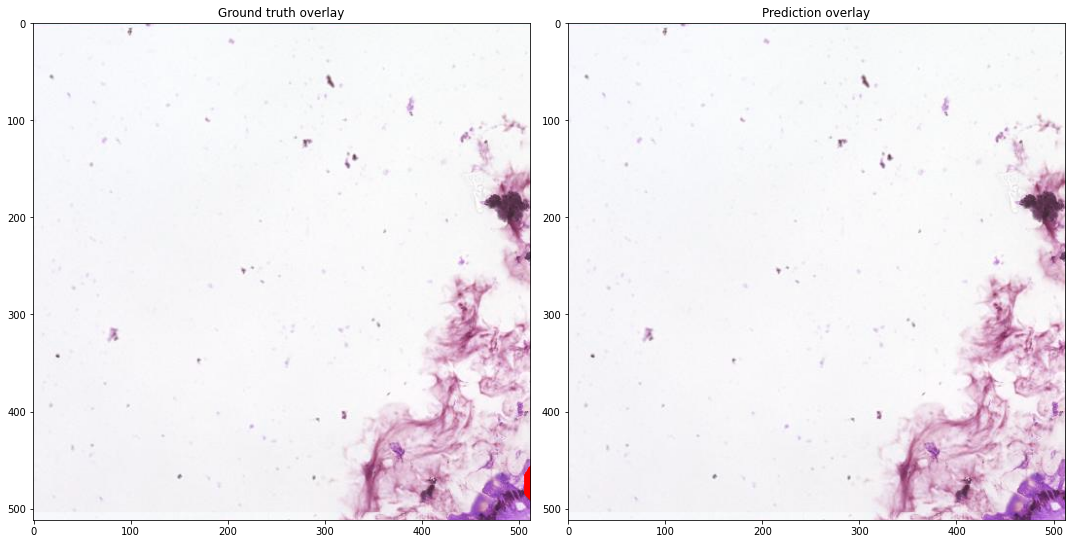

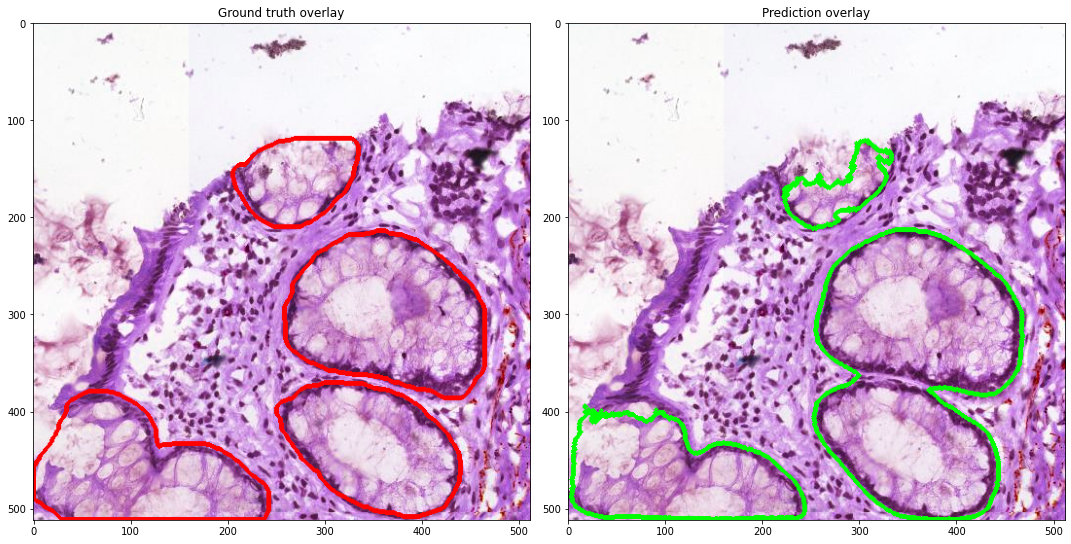

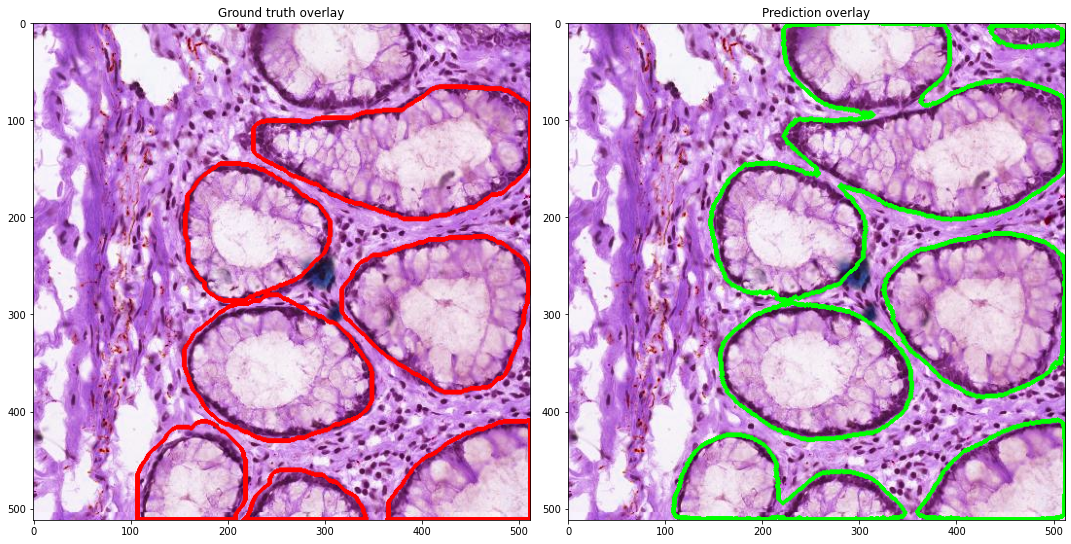

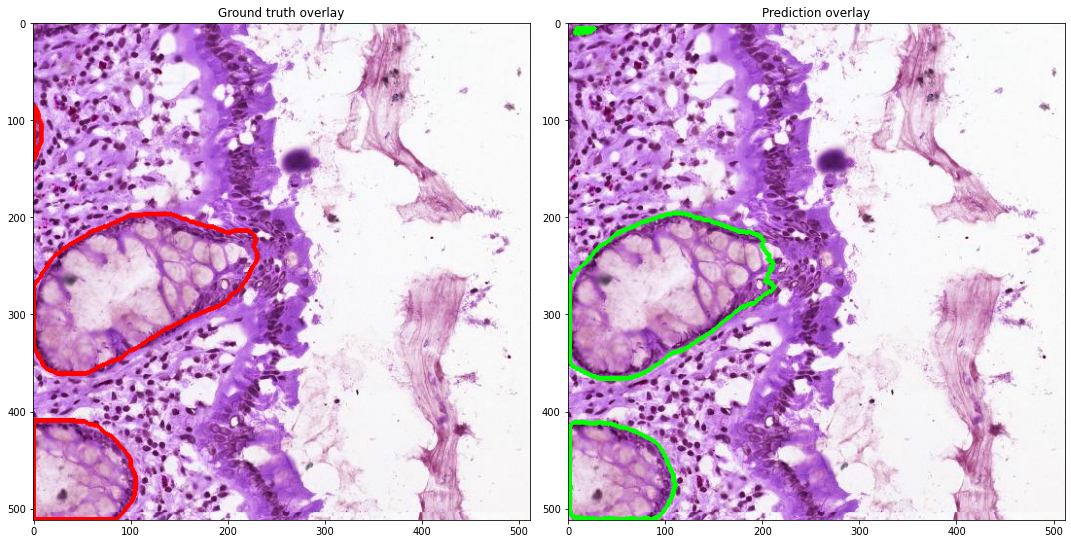

overlays for HandE_B005_CL_b_RGB_bottomleft


In [15]:
test_prediction_overlays(test_data_path,model_List,df_test,overlay_save_path="overlays/",n_show=4)